# ann-project

5조
한수호, 강구현, 김민규, 홍준기

# Setup

In [2]:
from models.simple_cnn import CNNModel
from models.residual import ResModel
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import callbacks, optimizers, layers
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import seaborn as sns
import pickle
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-05-31 17:10:39.554326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 17:10:39.554363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 17:10:39.554399: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 17:10:39.561224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 17:10:40.261985: W tensorflow/compiler/

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [4]:
from datetime import datetime
result_path = './results'
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

dataset

In [5]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Data dimensions and sizes
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

# Prepare data
x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)  # 62 classes for EMNIST ByClass
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

# Integer labels for sparse categorical crossentropy
y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

# Split the training data into training and validation sets
_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

# Prepare data for ResNet
x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

2024-05-31 17:11:09.515293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 17:11:09.543293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 17:11:09.543586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

checkpoints

In [6]:
def create_callbacks(model_name):
    current_time = int(time.time())
    checkpoint_path = f"./checkpoints/checkpoints_{model_name}/weights.{current_time}.hdf5"
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    return [early_stopping, reduce_lr, checkpoint]


callbacks_lenet = create_callbacks('lenet')
callbacks_resnet = create_callbacks('resnet')
callbacks_ours_1 = create_callbacks('ours_1')
callbacks_ours_2 = create_callbacks('ours_2')
callbacks_final = create_callbacks('final')
result_path = './results'

test results

In [7]:
def save_results(results_df):
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    results_df.to_csv(os.path.join(result_path, f'result_{_time}.csv'), index=False)

saving history

In [8]:
def save_history(histories, filename):
    with open(os.path.join(result_path, filename), 'w') as f:
        json.dump(histories, f)

# 1. baseline과 our 모델 비교

In [ ]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model_1 = CNNModel()
our_model_2res = ResModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = []
training_time = []

In [ ]:
EPOCHS = 30
BATCH_SIZE = 500

In [ ]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized,
               y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_1.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_1]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_2]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_our1, acc_our1 = our_model_1.evaluate(x_test, y_test_int)
loss_our2, acc_our2 = our_model_2res.evaluate(x_test, y_test_int)

In [ ]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

In [ ]:
models = ["lenet-5", "resnet-50", "our_model_cnn", "our_model_residual"]
for model_name, h in zip(models, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_{model_name}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()
save_history(history, f'history_activation_{_time}.pkl')

In [ ]:
training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

# 2. Experiment

## 2.1. Optimizer

In [ ]:
optimizers_list = [
    optimizers.SGD(learning_rate=0.001, momentum=0.9),
    optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    optimizers.Adagrad(learning_rate=0.001),
    optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
]

In [ ]:
history = []
results = {'Optimizer': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_opt(x_train, y_train, validation_data, optimizer, activation_ftn='ReLU'):
    print(f"Start with {type(optimizer).__name__}")
    final_model = ResModel(num_classes=62, initial_filters=32,
                           dropout_rate=0.3, final_dropout_rate=0.6, activation=activation_ftn, num_residual_units=3)
    optimizer.build(final_model.model.trainable_variables)

    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Optimizer'].append(type(optimizer).__name__)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {type(optimizer).__name__}")

In [ ]:
EPOCHS = 10
BATCH_SIZE = 500

In [ ]:
for optimizer in optimizers_list:
    _train_opt(x_train, y_train_int, (x_valid, y_valid_int), optimizer, activation_ftn='ReLU')

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for optimizer, h in zip(optimizers_list, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_optimizer_{type(optimizer).__name__}_{_time}.json')

In [ ]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Optimizer", y=metric, hue="Optimizer", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Optimizer')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

## 2.2. Activation Function

In [ ]:
activations = {
    'relu': layers.ReLU(),
    'leaky_relu': layers.LeakyReLU(),
    'elu': layers.ELU(),
    'selu': layers.Activation('selu'),
    'sigmoid': layers.Activation('sigmoid'),
    'tanh': layers.Activation('tanh'),
    'softmax': layers.Activation('softmax'),
    'softplus': layers.Activation('softplus'),
    'softsign': layers.Activation('softsign'),
    'swish': layers.Activation('swish'),
    'gelu': layers.Activation('gelu')
}

In [ ]:
history = []
results = {'Activation Function': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
activation_functions = ['relu', 'leaky_relu', 'elu', 'selu', 'sigmoid', 'tanh',
                        'softmax', 'softplus', 'softsign', 'swish', 'gelu']

In [ ]:
def _train_act(x_train, y_train, validation_data, optimizer, activation_ftn):
    print(f"Start with {activation_ftn}")

    activation_layer = activations.get(activation_ftn, layers.ReLU())

    final_model = ResModel(num_classes=62, initial_filters=32, dropout_rate=0.3,
                           final_dropout_rate=0.6, activation=activation_layer, num_residual_units=3)
    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Activation Function'].append(activation_ftn)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {activation_ftn}")

In [ ]:
EPOCHS = 10
BATCH_SIZE = 500

In [15]:
for ftn in activation_functions:
    _train_act(x_train, y_train_int, (x_valid, y_valid_int), optimizer=best_optimizer, activation_ftn=ftn)

Start with relu
Epoch 1/10


2024-05-30 19:29:24.342273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.8266
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 29s 22ms/step - loss: 0.5105 - accuracy: 0.8266 - val_loss: 0.3741 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8578
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 26s 21ms/step - loss: 0.3917 - accuracy: 0.8578 - val_loss: 0.3548 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8633
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 26s 21ms/step - loss: 0.3720 - accuracy: 0.8633 - val_loss: 0.3490 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 4/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.3601 - accuracy: 0.8668
Epoch 4: val_loss did not improve 

2024-05-30 19:34:17.358092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5466 - accuracy: 0.8152
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 32s 23ms/step - loss: 0.5465 - accuracy: 0.8152 - val_loss: 0.4033 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.4192 - accuracy: 0.8496
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 28s 22ms/step - loss: 0.4192 - accuracy: 0.8496 - val_loss: 0.3811 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.8556
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 22ms/step - loss: 0.3975 - accuracy: 0.8556 - val_loss: 0.3776 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8589
Epoch 4: val_loss did not improve 

2024-05-30 19:39:16.695954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5716 - accuracy: 0.8088
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 30s 22ms/step - loss: 0.5715 - accuracy: 0.8088 - val_loss: 0.4127 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4238 - accuracy: 0.8478
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 22ms/step - loss: 0.4239 - accuracy: 0.8478 - val_loss: 0.3875 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 3/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3985 - accuracy: 0.8553
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 21ms/step - loss: 0.3985 - accuracy: 0.8553 - val_loss: 0.3671 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.8594
Epoch 4: val_loss did not improve 

2024-05-30 19:44:14.882920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.7894
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 30s 22ms/step - loss: 0.6514 - accuracy: 0.7895 - val_loss: 0.4329 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4524 - accuracy: 0.8403
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 21ms/step - loss: 0.4525 - accuracy: 0.8403 - val_loss: 0.4149 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4220 - accuracy: 0.8490
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 22ms/step - loss: 0.4220 - accuracy: 0.8490 - val_loss: 0.3949 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8537
Epoch 4: val_loss did not improve 

2024-05-30 19:49:08.548101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_35/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.7772 - accuracy: 0.7573
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 30s 22ms/step - loss: 0.7772 - accuracy: 0.7573 - val_loss: 0.5006 - val_accuracy: 0.8236 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4702 - accuracy: 0.8357
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 22ms/step - loss: 0.4702 - accuracy: 0.8357 - val_loss: 0.4277 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 3/10
1257/1257 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.8455
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 22ms/step - loss: 0.4330 - accuracy: 0.8455 - val_loss: 0.3951 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4128 - accuracy: 0.8515
Epoch 4: val_loss did not improve 

2024-05-30 19:54:01.258669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.8058
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 29s 22ms/step - loss: 0.5847 - accuracy: 0.8058 - val_loss: 0.4032 - val_accuracy: 0.8551 - lr: 5.0000e-04
Epoch 2/10
1257/1257 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.8459
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 26s 21ms/step - loss: 0.4330 - accuracy: 0.8459 - val_loss: 0.3898 - val_accuracy: 0.8594 - lr: 5.0000e-04
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8533
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 21ms/step - loss: 0.4071 - accuracy: 0.8533 - val_loss: 0.3817 - val_accuracy: 0.8616 - lr: 5.0000e-04
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8571
Epoch 4: val_loss did 

2024-05-30 19:58:59.804889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_9/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 2.7863 - accuracy: 0.5495
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 34s 24ms/step - loss: 2.7862 - accuracy: 0.5495 - val_loss: 1.9428 - val_accuracy: 0.7443 - lr: 5.0000e-04
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 1.9451 - accuracy: 0.6340
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 29s 23ms/step - loss: 1.9450 - accuracy: 0.6340 - val_loss: 1.4179 - val_accuracy: 0.7669 - lr: 5.0000e-04
Epoch 3/10
1256/1257 [============================>.] - ETA: 0s - loss: 1.6796 - accuracy: 0.6461
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 30s 24ms/step - loss: 1.6796 - accuracy: 0.6461 - val_loss: 1.1391 - val_accuracy: 0.7795 - lr: 5.0000e-04
Epoch 4/10
1256/1257 [============================>.] - ETA: 0s - loss: 1.5214 - accuracy: 0.6567
Epoch 4: val_loss did 

2024-05-30 20:04:16.312651: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.7914
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 31s 23ms/step - loss: 0.6437 - accuracy: 0.7914 - val_loss: 0.4180 - val_accuracy: 0.8484 - lr: 5.0000e-04
Epoch 2/10
1257/1257 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8427
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 28s 22ms/step - loss: 0.4432 - accuracy: 0.8427 - val_loss: 0.3991 - val_accuracy: 0.8553 - lr: 5.0000e-04
Epoch 3/10
1257/1257 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.8505
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 21ms/step - loss: 0.4142 - accuracy: 0.8505 - val_loss: 0.3873 - val_accuracy: 0.8554 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.8556
Epoch 4: val_loss did 

2024-05-30 20:09:19.278703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_11/dropout_58/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5726 - accuracy: 0.8094
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 31s 23ms/step - loss: 0.5725 - accuracy: 0.8094 - val_loss: 0.4102 - val_accuracy: 0.8529 - lr: 5.0000e-04
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8460
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 27s 22ms/step - loss: 0.4334 - accuracy: 0.8461 - val_loss: 0.3972 - val_accuracy: 0.8579 - lr: 5.0000e-04
Epoch 3/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.4112 - accuracy: 0.8525
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 28s 22ms/step - loss: 0.4112 - accuracy: 0.8524 - val_loss: 0.3780 - val_accuracy: 0.8618 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.8561
Epoch 4: val_loss did 

2024-05-30 20:14:19.617770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_60/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8337
Epoch 1: val_loss did not improve from 0.32420
1257/1257 [==============================] - 35s 26ms/step - loss: 0.4829 - accuracy: 0.8337 - val_loss: 0.3727 - val_accuracy: 0.8604 - lr: 5.0000e-04
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3827 - accuracy: 0.8601
Epoch 2: val_loss did not improve from 0.32420
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3827 - accuracy: 0.8601 - val_loss: 0.3552 - val_accuracy: 0.8677 - lr: 5.0000e-04
Epoch 3/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8651
Epoch 3: val_loss did not improve from 0.32420
1257/1257 [==============================] - 32s 25ms/step - loss: 0.3642 - accuracy: 0.8651 - val_loss: 0.3477 - val_accuracy: 0.8704 - lr: 5.0000e-04
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8684
Epoch 4: val_loss did 

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1257/1257 [==============================] - 32s 25ms/step - loss: 0.3295 - accuracy: 0.8753 - val_loss: 0.3219 - val_accuracy: 0.8786 - lr: 5.0000e-04
Epoch 9/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8761
Epoch 9: val_loss did not improve from 0.32191
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3257 - accuracy: 0.8761 - val_loss: 0.3244 - val_accuracy: 0.8772 - lr: 5.0000e-04
Epoch 10/10
1257/1257 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8775
Epoch 10: val_loss did not improve from 0.32191
3636/3636 [==============================] - 9s 3ms/step - loss: 0.3173 - accuracy: 0.8781
End with swish
Start with gelu
Epoch 1/10


2024-05-30 20:19:55.808374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_65/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.8323
Epoch 1: val_loss did not improve from 0.32191
1257/1257 [==============================] - 38s 29ms/step - loss: 0.4893 - accuracy: 0.8323 - val_loss: 0.3648 - val_accuracy: 0.8633 - lr: 5.0000e-04
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8606
Epoch 2: val_loss did not improve from 0.32191
1257/1257 [==============================] - 34s 27ms/step - loss: 0.3807 - accuracy: 0.8606 - val_loss: 0.3498 - val_accuracy: 0.8684 - lr: 5.0000e-04
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3617 - accuracy: 0.8663
Epoch 3: val_loss did not improve from 0.32191
1257/1257 [==============================] - 35s 28ms/step - loss: 0.3617 - accuracy: 0.8663 - val_loss: 0.3452 - val_accuracy: 0.8710 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3513 - accuracy: 0.8691
Epoch 4: val_loss did 

In [17]:
results_df = pd.DataFrame(results)
save_results(results_df)
for activation, h in zip(activation_functions, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_activation_{activation}_{_time}.json')

In [19]:
len(history)

12

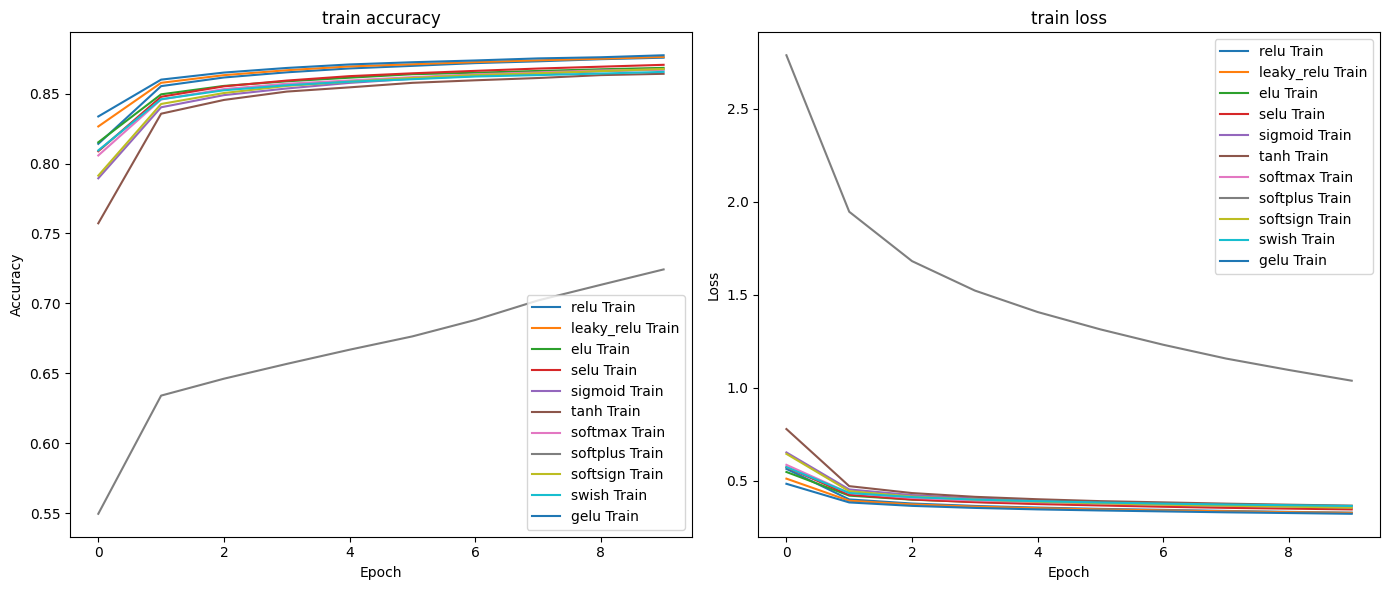

In [22]:
plt.figure(figsize=(14, 6))

for i in range(len(activation_functions)):
    plt.subplot(1, 2, 1)
    plt.plot(history[i].history['accuracy'], label=f'{activation_functions[i]} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history[i].history['loss'], label=f'{activation_functions[i]} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_activation_{_time}.png")
plt.show()

In [24]:
display(results_df)

,Activation Function,Loss,Accuracy,Training Time
0,relu,0.319327,0.878312,284.693108
1,relu,0.318679,0.878054,280.359301
2,leaky_relu,0.339561,0.869887,288.029077
3,elu,0.328099,0.875965,285.020607
4,selu,0.335291,0.873919,281.828859
5,sigmoid,0.379131,0.859476,282.889556
6,tanh,0.338031,0.872019,282.937504
7,softmax,0.548433,0.847080,305.238621
8,softplus,0.336844,0.871056,288.652585
9,softsign,0.344829,0.870687,288.538176


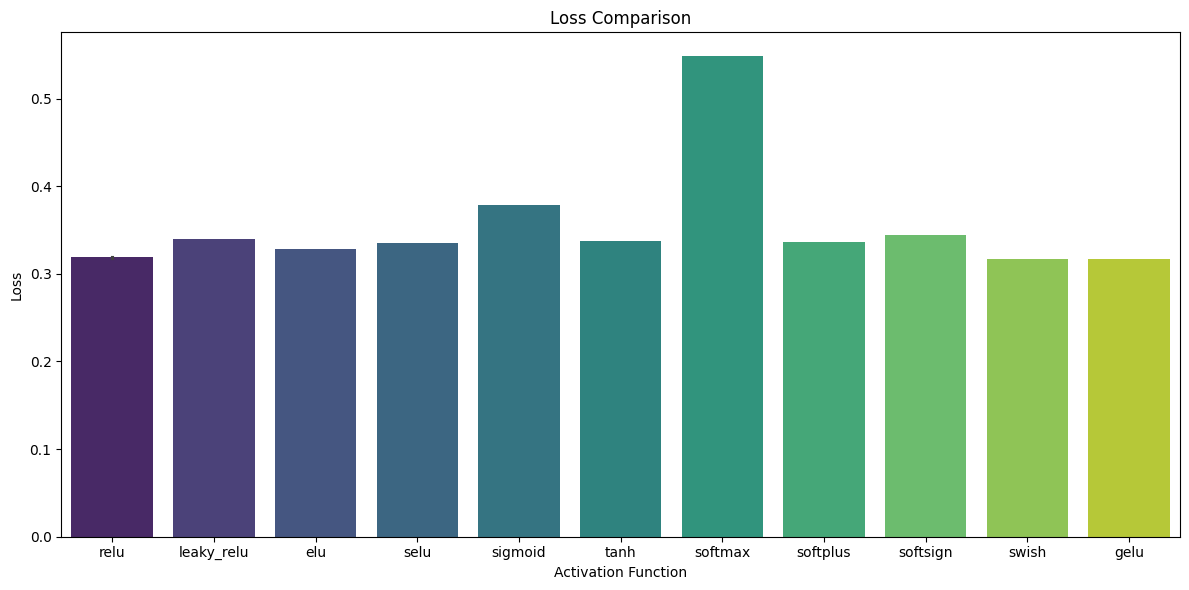

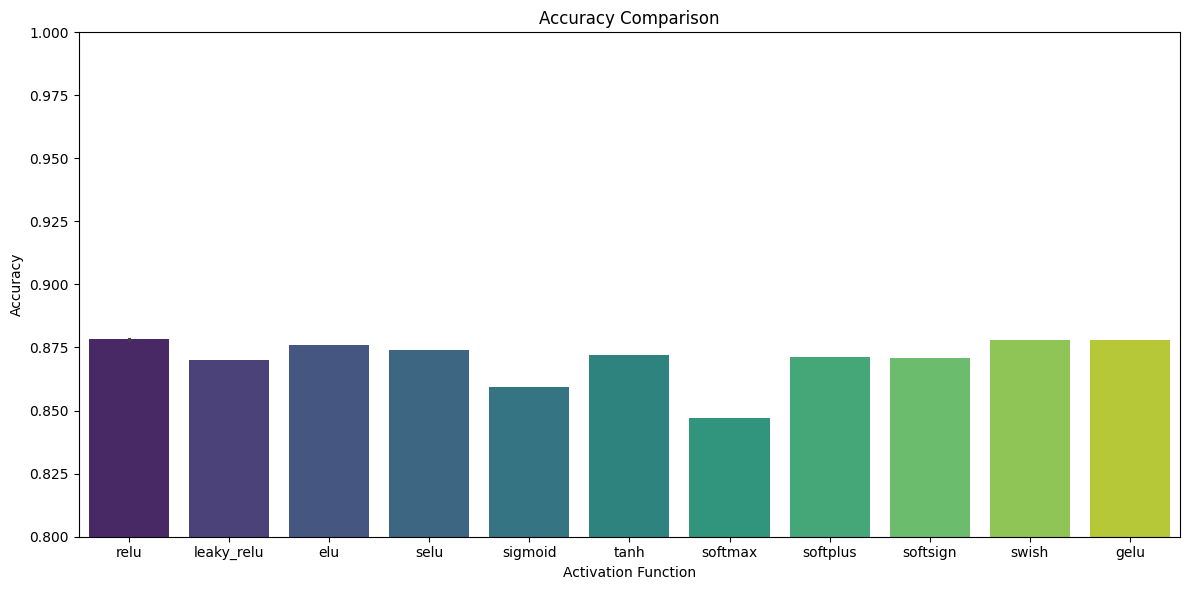

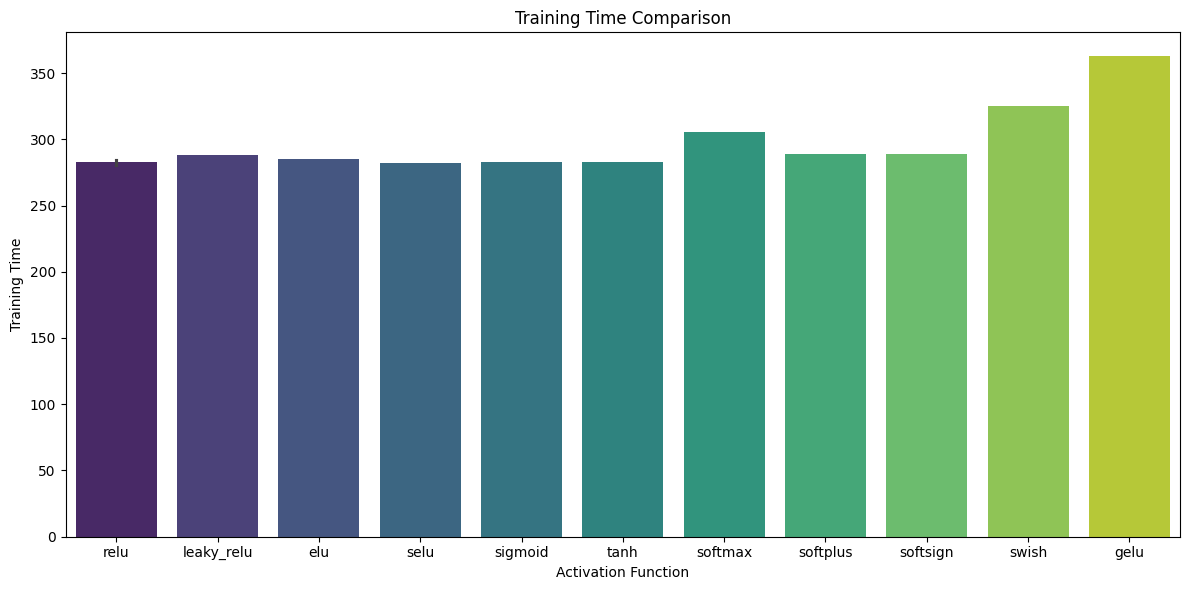

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Loss", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Loss"} Comparison')
plt.ylabel("Loss")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Loss".lower().replace(" ", "_")}_comparison_{_time}.png')

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Accuracy", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Accuracy"} Comparison')
plt.ylabel("Accuracy")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Accuracy".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Training Time", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Training Time"} Comparison')
plt.ylabel("Training Time")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Training Time".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

## 2.3. The number of Residual Blocks

In [27]:
history = []
training_time = []

In [28]:
callbacks_final = create_callbacks('final')

In [29]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_activation = layers.Activation('swish')

In [30]:
our_model_1res = ResModel(num_residual_units=1, activation=best_activation)
our_model_2res = ResModel(num_residual_units=2, activation=best_activation)
our_model_3res = ResModel(num_residual_units=3, activation=best_activation)
our_model_4res = ResModel(num_residual_units=4, activation=best_activation)

In [31]:
our_model_1res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
EPOCHS = 50
BATCH_SIZE = 500

In [33]:
def _train_blocks(model, x_train, y_train, validation_data):
    model.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [34]:
start_time = time.time()
_train_blocks(our_model_1res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

start_time = time.time()
_train_blocks(our_model_2res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_3res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_4res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50
   1/1257 [..............................] - ETA: 26:03 - loss: 4.9202 - accuracy: 0.0140

2024-05-30 20:31:57.333827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_70/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5501 - accuracy: 0.8189
Epoch 1: val_loss improved from inf to 0.39629, saving model to ./checkpoints/checkpoints_final/weights.1717068708.hdf5
1257/1257 [==============================] - 22s 17ms/step - loss: 0.5501 - accuracy: 0.8190 - val_loss: 0.3963 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 2/50
   5/1257 [..............................] - ETA: 19s - loss: 0.4084 - accuracy: 0.8568

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1257/1257 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8538
Epoch 2: val_loss improved from 0.39629 to 0.37166, saving model to ./checkpoints/checkpoints_final/weights.1717068708.hdf5
1257/1257 [==============================] - 20s 16ms/step - loss: 0.4077 - accuracy: 0.8538 - val_loss: 0.3717 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3852 - accuracy: 0.8595
Epoch 3: val_loss improved from 0.37166 to 0.35664, saving model to ./checkpoints/checkpoints_final/weights.1717068708.hdf5
1257/1257 [==============================] - 20s 16ms/step - loss: 0.3852 - accuracy: 0.8595 - val_loss: 0.3566 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 4/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3721 - accuracy: 0.8629
Epoch 4: val_loss improved from 0.35664 to 0.34746, saving model to ./checkpoints/checkpoints_final/weights.1717068708.hdf5
1257/1257 [==============================] - 20s 

2024-05-30 20:49:13.906116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 3.5215 - accuracy: 0.2043
Epoch 1: val_loss did not improve from 0.32191
1257/1257 [==============================] - 28s 21ms/step - loss: 3.5215 - accuracy: 0.2043 - val_loss: 2.3442 - val_accuracy: 0.5010 - lr: 1.0000e-06
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 2.6392 - accuracy: 0.3931
Epoch 2: val_loss did not improve from 0.32191
1257/1257 [==============================] - 26s 21ms/step - loss: 2.6390 - accuracy: 0.3931 - val_loss: 1.9255 - val_accuracy: 0.5535 - lr: 1.0000e-06
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 2.2604 - accuracy: 0.4687
Epoch 3: val_loss did not improve from 0.32191
1257/1257 [==============================] - 26s 21ms/step - loss: 2.2605 - accuracy: 0.4687 - val_loss: 1.6798 - val_accuracy: 0.5945 - lr: 1.0000e-06
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 2.0166 - accuracy: 0.5141
Epoch 4: val_loss did 

KeyboardInterrupt: 

In [ ]:
loss_our1res, acc_our1res = our_model_1res.evaluate(x_test, y_test_int)
loss_our2res, acc_our2res = our_model_2res.evaluate(x_test, y_test_int)
loss_our3res, acc_our3res = our_model_3res.evaluate(x_test, y_test_int)
loss_our4res, acc_our4res = our_model_4res.evaluate(x_test, y_test_int)

In [ ]:
results = {
    "Model": ["Our Model(Residual, 1 units)", "Our Model(Residual, 2 units)", "Our Model(Residual, 3 units)", "Our Model(Residual, 4 units)"],
    "Loss": [loss_our1res, loss_our2res, loss_our3res, loss_our4res],
    "Accuracy": [acc_our1res, acc_our2res, acc_our3res, acc_our4res],
    "Training Time": training_time
}

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_blocks_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 5), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_block_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_blocks_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_blocks_{_time}.png')
    plt.show()

## 2.4. Learning Rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_optimizer_1 = optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
best_optimizer_2 = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_optimizer_3 = optimizers.legacy.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
best_optimizer_4 = optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
best_optimizer_5 = optimizers.legacy.Nadam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999)
best_activation = layers.Activation('swish')

In [ ]:
our_model_1lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_2lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_3lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_4lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_5lr = ResModel(num_residual_units=3, activation=best_activation)

In [ ]:
our_model_1lr.compile(optimizer=best_optimizer_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2lr.compile(optimizer=best_optimizer_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3lr.compile(optimizer=best_optimizer_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4lr.compile(optimizer=best_optimizer_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_5lr.compile(optimizer=best_optimizer_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:


def _train_lr(model, optimizer, x_train, y_train, validation_data):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
start_time = time.time()
_train_lr(our_model_1lr, best_optimizer_1, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_1')

start_time = time.time()
_train_lr(our_model_2lr, best_optimizer_2, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_2')


start_time = time.time()
_train_lr(our_model_3lr, best_optimizer_3, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_3')

start_time = time.time()
_train_lr(our_model_4lr, best_optimizer_4, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_4')

start_time = time.time()
_train_lr(our_model_5lr, best_optimizer_5, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_5')

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 4), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

## 2.5. Loss function